## Amazon Product Sentiment Analysis Introduction

In this project, I examine sentiment analysis on Amazon product reviews using both balanced and sample datasets to explore how sentiment classification varies across data conditions. The balanced dataset contains an equal number of positive, neutral, and negative reviews, allowing me to compare the models' accuracy across all sentiment types without bias. The sample dataset represents real-world distributions with a predominance of positive reviews, providing insights into model performance under naturally imbalanced conditions.<br><br>

 By comparing these models across balanced and sample datasets, I assess their strengths and limitations in handling skewed data distributions, especially in differentiating between neutral and polarized sentiments.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import nltk_downloads
from transformers import AutoTokenizer

plt.style.use('ggplot')

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/christina___99/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /Users/christina___99/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /Users/christina___99/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package maxent_ne_chunker_tab to
[nltk_data]     /Users/christina___99/nltk_data...
[nltk_data]   Package maxent_ne_chunker_tab is already up-to-date!
[nltk_data] Downloading package words to
[nltk_data]     /Users/christina___99/nltk_data...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/christina___99/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


NLTK resource check completed.


In [2]:
df = pd.read_csv('Reviews.csv')

In [3]:
df.shape

(568454, 10)

In [4]:
df.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


There are 74258 unique products in this dataset

In [5]:
df['ProductId'].nunique()

74258

In [6]:
df.columns

Index(['Id', 'ProductId', 'UserId', 'ProfileName', 'HelpfulnessNumerator',
       'HelpfulnessDenominator', 'Score', 'Time', 'Summary', 'Text'],
      dtype='object')

In [7]:
df = df.drop(columns=['ProductId', 'UserId', 'ProfileName', 'HelpfulnessNumerator',
                      'HelpfulnessDenominator', 'Time', 'Summary'])

In [8]:
df['TrueLabel'] = 'neutral'

df.loc[df['Score'].isin([1, 2]), 'TrueLabel'] = 'negative'

df.loc[df['Score'].isin([4, 5]), 'TrueLabel'] = 'positive'

In [9]:
df.head()

,Id,Score,Text,TrueLabel
0,1,5,I have bought several of the Vitality canned d...,positive
1,2,1,Product arrived labeled as Jumbo Salted Peanut...,negative
2,3,4,This is a confection that has been around a fe...,positive
3,4,2,If you are looking for the secret ingredient i...,negative
4,5,5,Great taffy at a great price. There was a wid...,positive


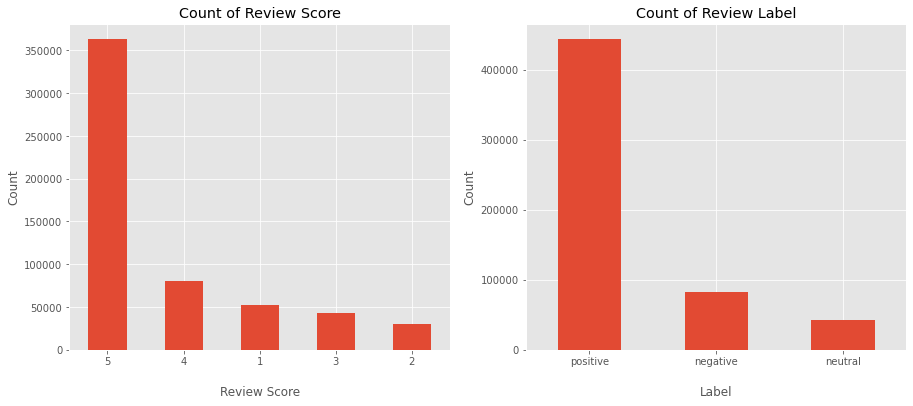

In [10]:
fig, ax = plt.subplots(1, 2, figsize=(15, 6))

df['Score'].value_counts().plot(kind='bar', ax=ax[0], xlabel='\nReview Score',
                                      ylabel='Count', title='Count of Review Score', rot=0)
df['TrueLabel'].value_counts().plot(kind='bar', ax=ax[1], xlabel='\nLabel',
                                      ylabel='Count', title='Count of Review Label', rot=0)
plt.show()

In [11]:
example = df['Text'][50]
example_score = df['Score'][50]
print(f'Text:  {example}\nScore: {example_score}')

Text:  This oatmeal is not good. Its mushy, soft, I don't like it. Quaker Oats is the way to go.
Score: 1


In [12]:
tokens = nltk.word_tokenize(example)
tokens[:10]

['This', 'oatmeal', 'is', 'not', 'good', '.', 'Its', 'mushy', ',', 'soft']

In [13]:
tag = nltk.pos_tag(tokens)
tag[:10]

[('This', 'DT'),
 ('oatmeal', 'NN'),
 ('is', 'VBZ'),
 ('not', 'RB'),
 ('good', 'JJ'),
 ('.', '.'),
 ('Its', 'PRP$'),
 ('mushy', 'NN'),
 (',', ','),
 ('soft', 'JJ')]

The `.post_tag()` method gives the part of speech of each token. This speech tagging is helpful for creating entities from each token.

In [14]:
entities = nltk.chunk.ne_chunk(tag)
entities.pprint()

(S
  This/DT
  oatmeal/NN
  is/VBZ
  not/RB
  good/JJ
  ./.
  Its/PRP$
  mushy/NN
  ,/,
  soft/JJ
  ,/,
  I/PRP
  do/VBP
  n't/RB
  like/VB
  it/PRP
  ./.
  (ORGANIZATION Quaker/NNP Oats/NNPS)
  is/VBZ
  the/DT
  way/NN
  to/TO
  go/VB
  ./.)


The reviews with greater than 512 tokens are removed from the original dataset using the `filter_tokens` function defined below. This is because RoBERTA pretrained models can only handle a maximum of 512 tokens.

In [15]:
def filter_tokens(df, text_column, model_name='cardiffnlp/twitter-roberta-base-sentiment', token_limit=512):

    tokenizer = AutoTokenizer.from_pretrained(model_name)

    def token_count(text):
        tokens = tokenizer.encode(text, add_special_tokens=True)  # Add special tokens for the model
        return len(tokens)

    df['token_count'] = df[text_column].apply(token_count)
    filtered_df = df[df['token_count'] <= token_limit]

    filtered_df = filtered_df.drop(columns=['token_count'])

    return filtered_df

In [16]:
filtered_df = filter_tokens(df, 'Text')

In [17]:
df.shape[0] - filtered_df.shape[0]

6005

In [18]:
filtered_df.to_csv('reviews_filtered.csv', index=False)

In [19]:
df1 = filtered_df[filtered_df['Score']==1].sample(250, random_state=42)
df2 = filtered_df[filtered_df['Score']==2].sample(250, random_state=42)
df3 = filtered_df[filtered_df['Score']==3].sample(500, random_state=42)
df4 = filtered_df[filtered_df['Score']==4].sample(250, random_state=42)
df5 = filtered_df[filtered_df['Score']==5].sample(250, random_state=42)

df_balance = pd.concat([df1, df2, df3, df4, df5])

In [20]:
df_sample = filtered_df.sample(1500, random_state=42)

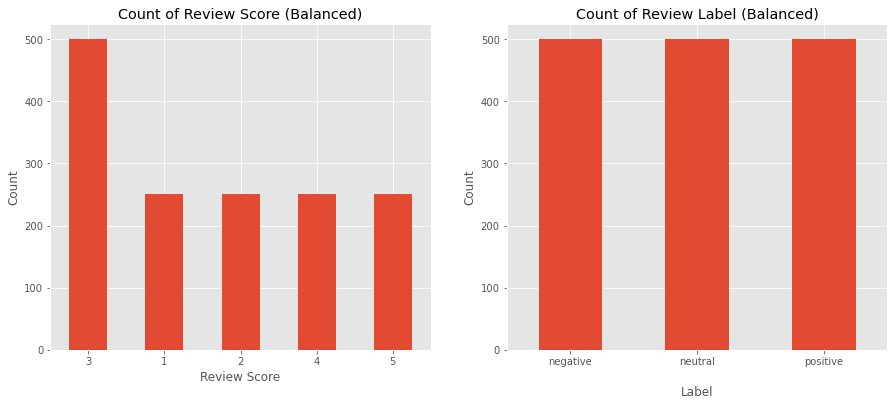

In [21]:
fig, ax = plt.subplots(1, 2, figsize=(15, 6))

df_balance['Score'].value_counts().plot(kind='bar', ax=ax[0], xlabel='Review Score',
                                      ylabel='Count', title='Count of Review Score (Balanced)', rot=0)
df_balance['TrueLabel'].value_counts().plot(kind='bar', ax=ax[1], xlabel='\nLabel',
                                      ylabel='Count', title='Count of Review Label (Balanced)', rot=0)
plt.show()

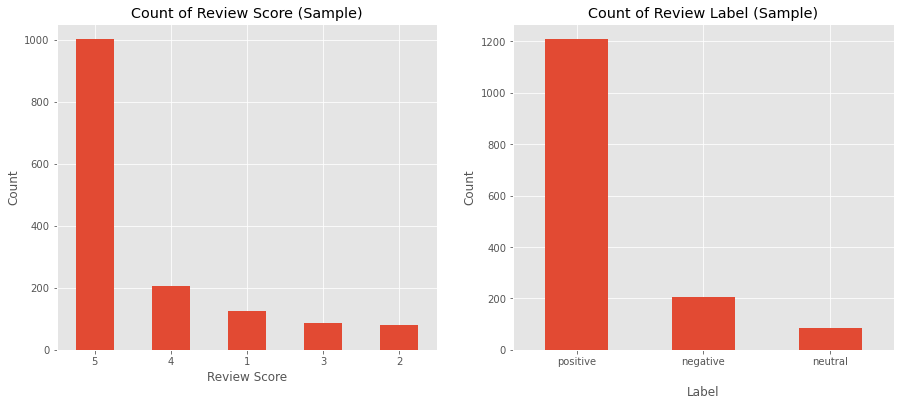

In [22]:
fig, ax = plt.subplots(1, 2, figsize=(15, 6))

df_sample['Score'].value_counts().plot(kind='bar', ax=ax[0], xlabel='Review Score',
                                      ylabel='Count', title='Count of Review Score (Sample)', rot=0)
df_sample['TrueLabel'].value_counts().plot(kind='bar', ax=ax[1], xlabel='\nLabel',
                                      ylabel='Count', title='Count of Review Label (Sample)', rot=0)
plt.show()

In [23]:
df_balance.to_csv('reviews_balance.csv', index=False)
df_sample.to_csv('reviews_sample.csv', index=False)